In [1]:
import sys
sys.path.append("../examples")

from ljspeech import get_dataset_iterator_ljspeech
loaded = list(get_dataset_iterator_ljspeech(False))

Загружаем датасет 'LJSpeech'...


C:\Users\Oleg\AppData\Local\Programs\Python\Python39\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for keithito/lj_speech contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/keithito/lj_speech
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Датасет 'LJSpeech' был успешно загружен


# Аналитика

## Пара слов о наборе

Набор данных состоит из 13100 коротких аудиозаписей одного спикера из 7 нефантастических книг на английском. Предполагаемые задачи -- ASR, T2S. Датасет является используемым [бенчмарком](https://paperswithcode.com/sota/text-to-speech-synthesis-on-ljspeech), поэтому какую-никакую пользу да представляет.

Каждая аудиозапись -- single-channel 16-bit PCM WAV with a sample rate of 22050 Hz.

На страницы HF есть статистика по набору, поэтому особо с ней запариваться не вижу смысла:
```
Total Clips: 13,100
Total Words: 225,715
Total Characters: 1,308,678
Total Duration: 23:55:17
Mean Clip Duration: 6.57 sec
Min Clip Duration: 1.11 sec
Max Clip Duration: 10.10 sec
Mean Words per Clip: 17.23
Distinct Words: 13,821
```

Книги, по которым был собран датасет:

* Morris, William, et al. Arts and Crafts Essays. 1893.
* Griffiths, Arthur. The Chronicles of Newgate, Vol. 2. 1884.
* Roosevelt, Franklin D. The Fireside Chats of Franklin Delano Roosevelt. 1933-42.
* Harland, Marion. Marion Harland's Cookery for Beginners. 1893.
* Rolt-Wheeler, Francis. The Science - History of the Universe, Vol. 5: Biology. 1910.
* Banks, Edgar J. The Seven Wonders of the Ancient World. 1916.
* President's Commission on the Assassination of President Kennedy. Report of the President's Commission on the Assassination of President Kennedy. 1964.

In [2]:
import pandas as pd

df = pd.DataFrame(loaded).set_index("id")
df

,audio,sampling_rate,file,text,normalized_text,duration
id,,,,,,
LJ001-0001,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ...",9.655011
LJ001-0002,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,in being comparatively modern.,in being comparatively modern.,1.899546
LJ001-0003,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,For although the Chinese took impressions from...,For although the Chinese took impressions from...,9.666621
LJ001-0004,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,"produced the block books, which were the immed...","produced the block books, which were the immed...",5.138730
LJ001-0005,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...,8.110884
...,...,...,...,...,...,...
LJ050-0274,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,made certain recommendations which it believes...,made certain recommendations which it believes...,4.500181
LJ050-0275,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,materially improve upon the procedures in effe...,materially improve upon the procedures in effe...,9.120952
LJ050-0276,None,22050,C:\Users\Oleg\.cache\huggingface\datasets\down...,"As has been pointed out, the Commission has no...","As has been pointed out, the Commission has no...",8.563673


In [3]:
import re
import nltk
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

sns.set_style('white')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['legend.frameon'] = True
palette = sns.color_palette('Set1')
sns.set_palette(palette)

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Oleg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
N = 20

# Препроцесс текста
def preprocess_text(text):
    if pd.isnull(text):
        return []
    # оставляем только буквы
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    words = text.split()
    # и не-стоп-слова
    return [word for word in words if word not in stop_words]


def plot_top_words(word_counts, title, ax=None):
    words, counts = zip(*word_counts)
    sns.barplot(x=list(counts), y=list(words), ax=ax, palette='viridis', hue=list(words), legend=False)
    if ax is not None:
        ax.set_title(title)
        ax.set_xlabel('Частота')
        ax.set_ylabel('Слова')
    else:
        plt.title(title)
        plt.xlabel('Частота')
        plt.ylabel('Слова')
        plt.show()

In [5]:
import numpy as np
from wordcloud import WordCloud
from matplotlib.colors import ListedColormap


def draw_wordcloud(texts, max_words=1000, width=900, height=400, random_state=10):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height, random_state=random_state)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()
    

def draw_cluster_clouds(data, clusters, n_clusters, alert_by='text', cloud_kwargs={}):
    for i in range(n_clusters):
        inds = np.argwhere(clusters == i).reshape((-1,))
        print('cluster: {}; samples: {}'.format(i + 1, len(inds)))
        if len(inds) == 0:
            print('empty')
            continue
        display(draw_wordcloud(data.iloc[inds][alert_by], **cloud_kwargs))


colors = {
    0: 'teal',
    1: 'darkturquoise',
    2: 'red',
    3: 'crimson',
    4: 'darkorange',
    5: 'gold',
    6: 'magenta',
    7: 'purple',
    8: 'darkorchid',
    9: 'lime',
    10: 'limegreen',
    11: 'mediumvioletred',
    12: 'sienna',
    13: 'limegreen',
    14: 'royalblue',
    15: 'mediumblue',
}


def plot_clustering(n_clusters, X_emb, labels, title='Clustering results'):
    palette = sns.color_palette('tab10', n_colors=50)
    cmap = ListedColormap(palette)
    
    for k in range(n_clusters):
        inds = np.argwhere(labels == k).reshape((-1,))      
        plt.scatter(X_emb[inds, 0], X_emb[inds, 1], c=colors[k], linewidths=0.3, alpha=0.6)

    if title != '':
        plt.title(title, fontsize=25)
        
    plt.legend(labels=[i + 1 for i in range(n_clusters)], loc='lower center',
               fontsize='x-large', ncol=8, markerscale=1.5,
               bbox_to_anchor=(0.5, -0.3))
    plt.show()

**Топ-20 слов**

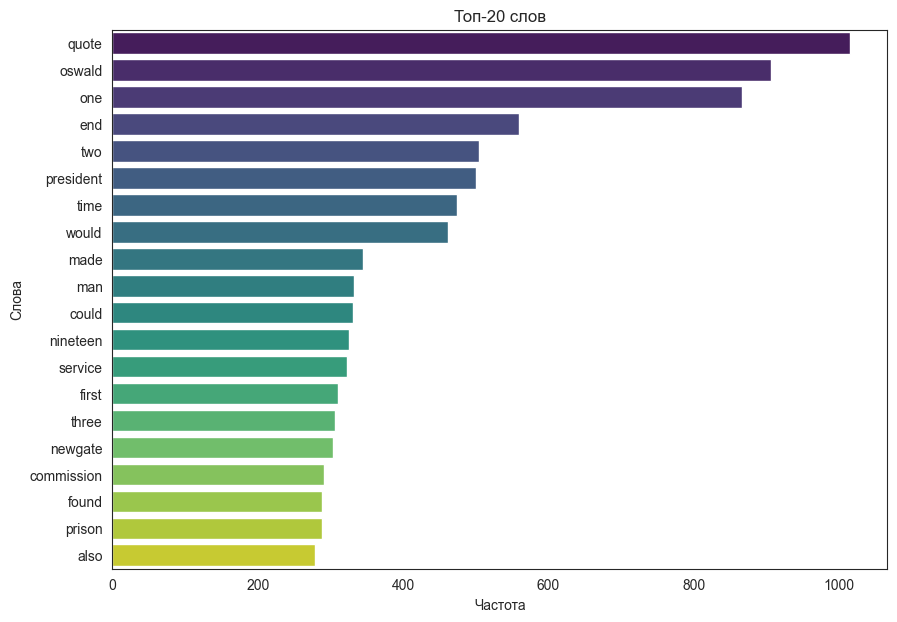

In [6]:
words = df['normalized_text'].apply(preprocess_text).explode()
wc = Counter(words).most_common(N)
plot_top_words(wc, title=f"Топ-{N} слов")

Малоинтересно: много числительных, а значит, и дат. Может, биграммы будут поинтереснее.

**Биграммы**

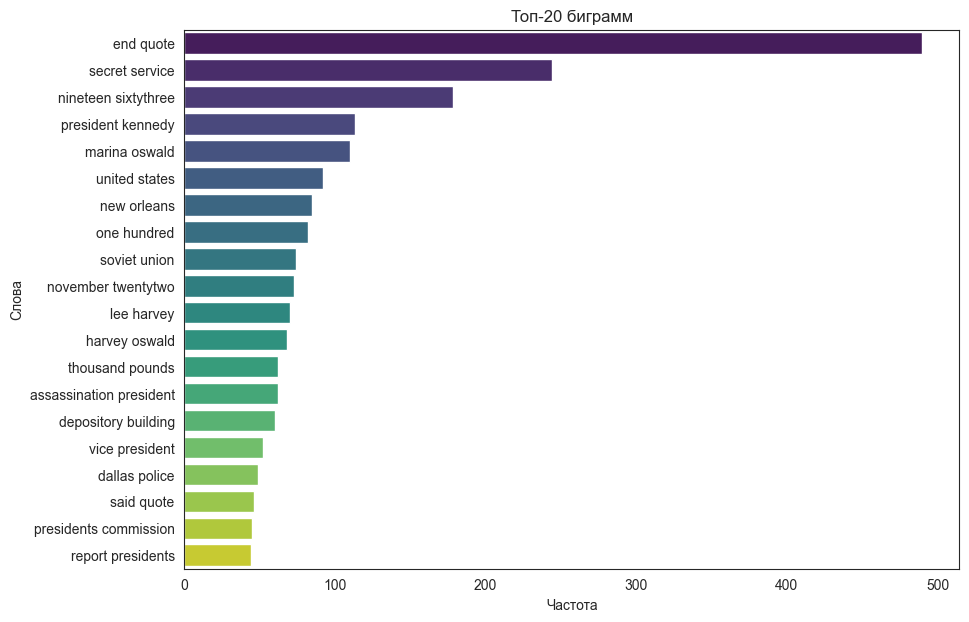

In [7]:
from nltk import ngrams

bigrams = list(ngrams(words, 2))
bigram_wc = Counter(bigrams).most_common(N)
bigram_wc = [(item[0][0] + ' ' + item[0][1], item[1]) for item in bigram_wc]
plot_top_words(bigram_wc, title=f"Топ-{N} биграмм")

Сплошная политика

**Тематмоделирование и кластеризация**

In [8]:
from sentence_transformers import SentenceTransformer

bert_name="cointegrated/LaBSE-en-ru"
labse_model = SentenceTransformer(bert_name)
embedds = labse_model.encode(df['normalized_text'].values)

C:\Users\Oleg\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
from sklearn.cluster import KMeans

n_clusters = 10

kmeans_kwargs = {
    'n_clusters': n_clusters,
    'init': 'k-means++',
    'tol': 1e-4,
    'max_iter': 1000,
    'random_state': 10,
    'algorithm': 'elkan',
}

km = KMeans(**kmeans_kwargs).fit(embedds)
labels_km = km.predict(embedds)

cluster: 1; samples: 1062


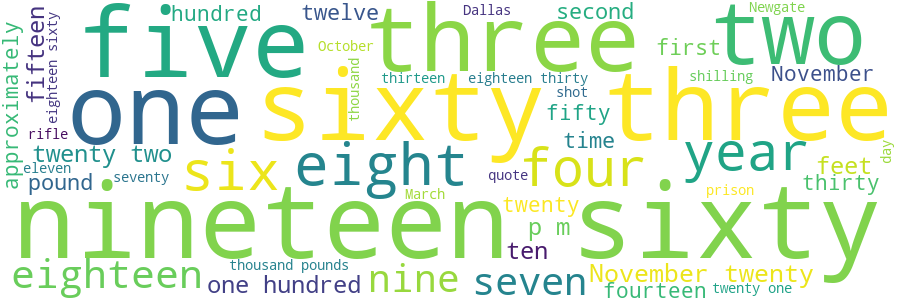

cluster: 2; samples: 1518


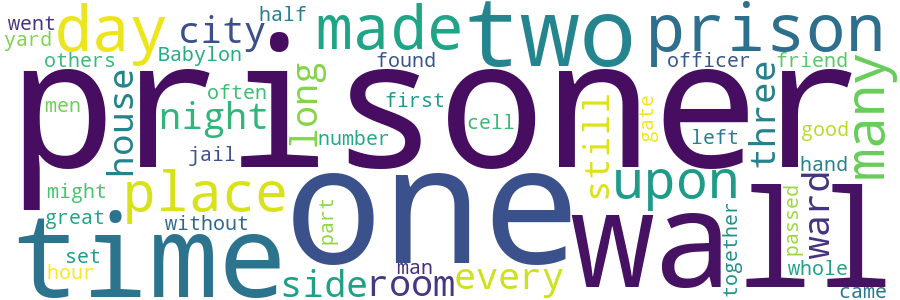

cluster: 3; samples: 1741


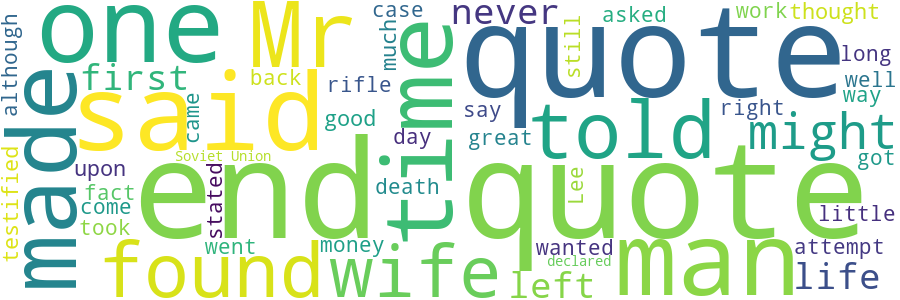

cluster: 4; samples: 1342


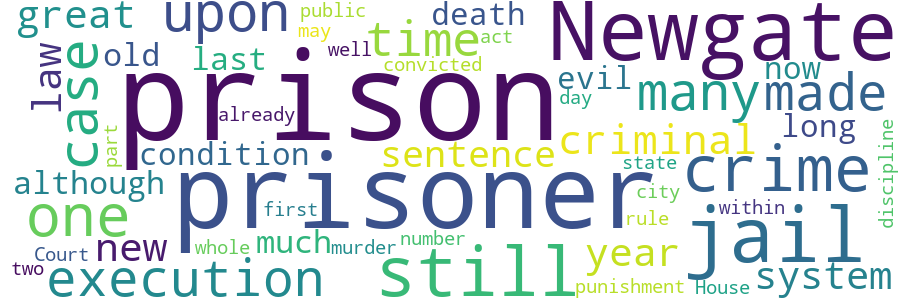

cluster: 5; samples: 1555


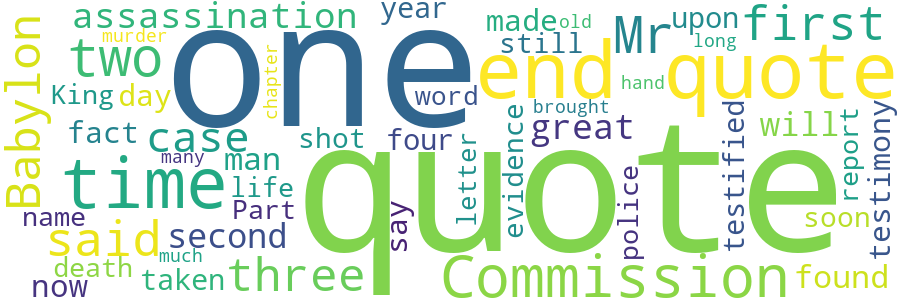

cluster: 6; samples: 620


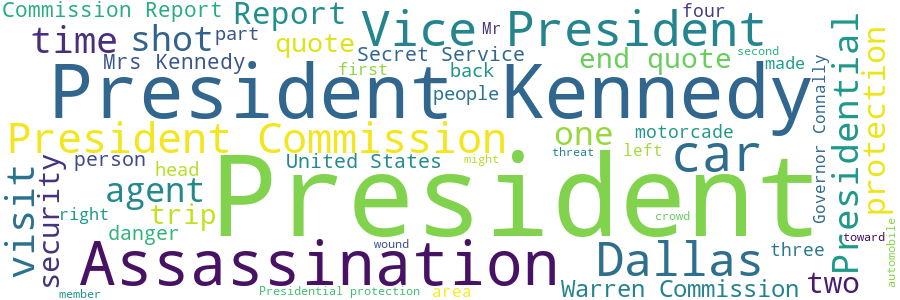

cluster: 7; samples: 1500


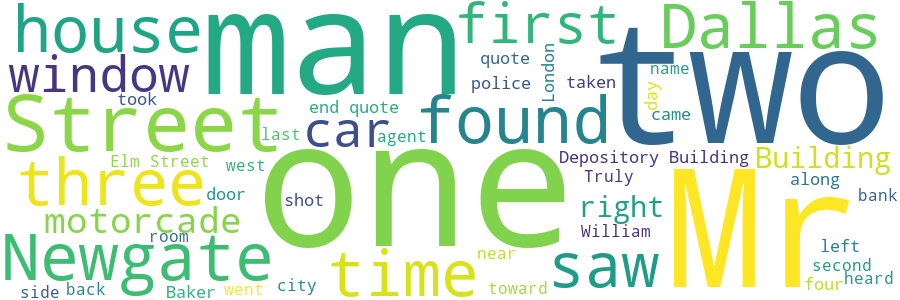

cluster: 8; samples: 2020


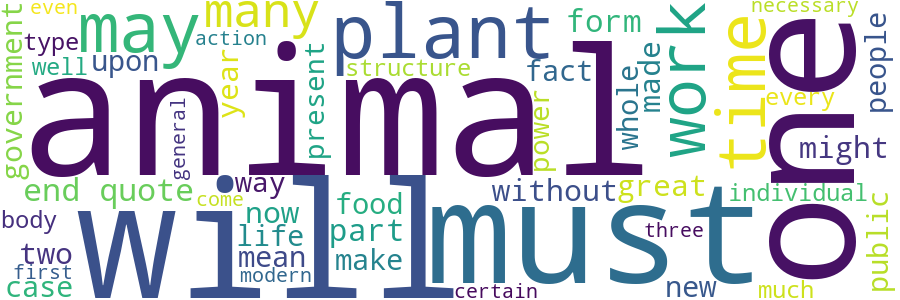

cluster: 9; samples: 1048


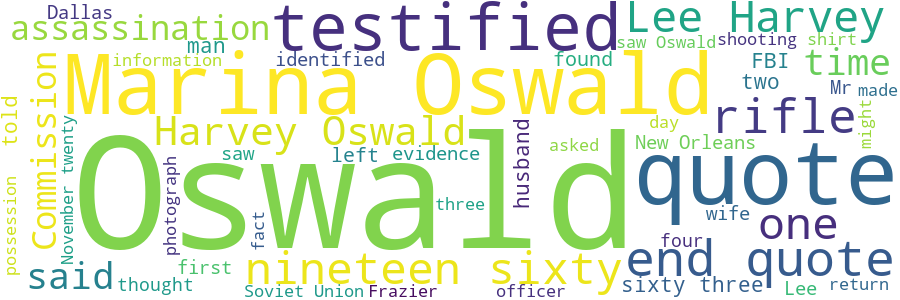

cluster: 10; samples: 694


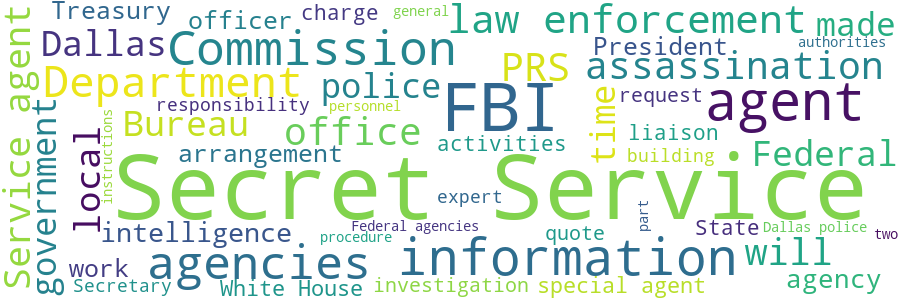

In [10]:
cloud_kwargs = {'max_words': 50, 'width': 900, 'height': 300}
draw_cluster_clouds(df, labels_km, n_clusters=n_clusters, alert_by='normalized_text', cloud_kwargs=cloud_kwargs)

In [11]:
from sklearn.manifold import TSNE

tsne_kwargs = {
    'metric': 'cosine',
    'learning_rate': 'auto',
    'min_grad_norm': 1e-5,
    'random_state': 10,
    'init': 'pca',
    'perplexity': 50,
    # 'method': 'barnes_hut',
}

tsne_embs = TSNE(**tsne_kwargs, n_jobs=-1).fit_transform(embedds)

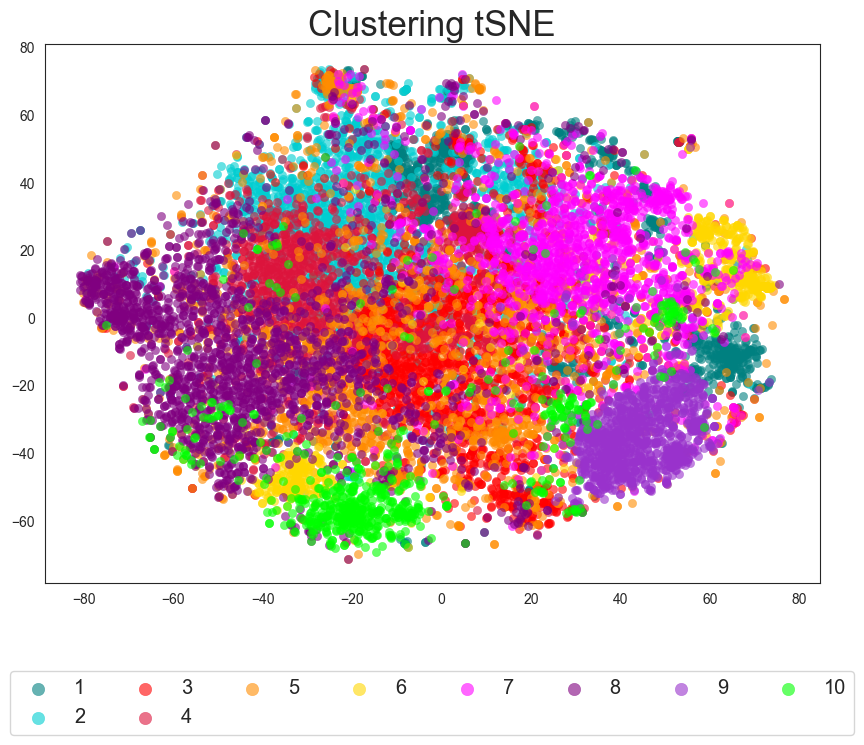

In [12]:
plot_clustering(n_clusters, tsne_embs, labels_km, "Clustering tSNE")

Какие-то темы выделяются хорошо, а где-то -- очень и очень шумно с большим размером. Много мусора в духе цитат и т.д.